In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from corner import corner
from scipy.special import binom
import emcee

from multiprocessing import Pool

# The problem

We want to know how well people classify AGN with mergers.

We have 8 classifiers and 144 classifiers, with 41 fake.

We want to know how many real mergers $M$ and isolated $N-M$.

We also have 70 control galaxies.

Base is $B=70$, control $C=74$, fake mergers $F_m=24$, and fake isolated galaxies$F_I=17$, and we have $N=8$ people classifying.

We want the number real mergers in $B$, $B_m$.


$B_j$ is the number of the mergers that classifier $j$ says.

$r_j$ is the true positive merger, $\hat F_{m,j}/F_{m,j}$, and a true positive isolated, $r'_j$, that is $\hat F_{I,j}/F_{I,j}$. Basically how many things they correctly called mergers that were mergers, and how many things they correctly identified as isolated mergers.


The likelihood should be
$$
L=\prod_j^N\sum_k f_b(k, B_m, r_j)f_b(B_j-k,B-B_m,1-r_j')
$$
He defined $f_b(k, B_m, r_j)$, which is the real merger rate, sort of a binomial distribution.

Also, we have $f_b(B_j-k, B-B_m, 1-r_j')$ as the isolated identified as a merger binomial.

$k$ is the number of observed, $B_m$ is the total sample, and $r_j$ is the probability.


So we are assuming $B_m$ total true mergers in the sample. We want to estimate that. By definition, there are $B-B_m$ true isolated variables in the sample.

Let's say then the person correctly classified $k$ mergers, and they mis-classified $B_j-k$.

OK, I think this basically makes sense. In this notation, 
$$
f_b(k, n, p) = \binom{n}{k}p^k(1-p)^k
$$

If we want to take into account the prior, we would want to have this prior distribution $f(\hat F_{m,j},F_{m,j},r_j)$ and $f(\hat F_{I,j}, F_{I,j}, r'_j)$. This makes the likelihood;
$$
L=\prod_j^N f(\hat F_{m,j},F_{m,j},r_j)f(\hat F_{I,j}, F_{I,j}, r'_j)\sum_k f_b(k, B_m, r_j)f_b(B_j-k,B-B_m,1-r_j')
$$


Let's look at a simple eample; for $B=70$ galaxies, and $B_j = 50$, they have a correct merger identification rate $r_j=16/24$, and a correct correct isolated merger rate $r_j'=11/70$.

In [2]:
def f_b(k, n, p):
    return binom(n,k)*p**k*(1-p)**(n-k)

In [3]:
def L(Bm, rj, rjp, Bj, B):
    L = 0
    Bm = Bm.astype(int)
    for k in range(Bj+1):
        L += f_b(k, Bm, rj)*f_b(Bj-k, B-Bm, 1-rjp)
    return L

Text(0.5, 0, 'Estimated true underlying mergers $B_m$')

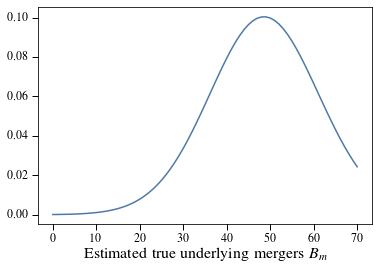

In [4]:
rj = 16/24
rjp = 11/17
Bj = 40
B = 70

Bm = np.arange(B+1)
plt.plot(Bm, L(Bm, rj, rjp, Bj, B))
plt.xlabel(r'Estimated true underlying mergers $B_m$')

35.375 7.192661190407901


Text(0.5, 0, 'Estimated true underlying mergers $B_m$')

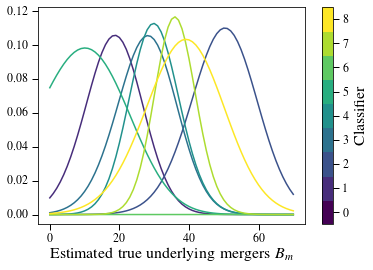

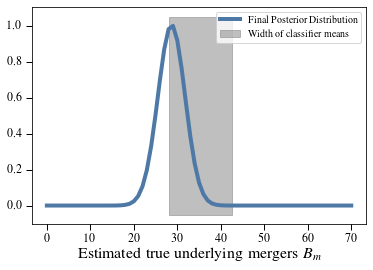

In [5]:
rjs = np.array([11, 16, 19, 20, 18, 17,18,20])/24
rjps = np.array([11, 14, 13, 12, 13, 8, 9, 13])/17
Bjs = np.array([50, 41, 45, 35, 39, 43, 44, 48])

rjs = np.array([0.75      , 0.79166667, 0.79166667, 0.66666667, 0.83333333, 0.79166667, 0.75, 0.75])
rjps = np.array([0.70588235, 0.58823529, 0.64705882, 0.82352941, 0.47058824,
       0.35294118, 0.82352941, 0.59])
Bjs = np.array([29, 48, 37, 27, 40, 27, 33, 42])

print(Bjs.mean(), Bjs.std())
#cm = plt.cm.viridis
cm = plt.cm.get_cmap('viridis', len(rjs)+1)

for i in range(len(rjs)):
    plt.plot(Bm, L(Bm, rjs[i], rjps[i], Bjs[i], B), color=cm((i+1)/(len(rjs)+1)))
plt.xlabel(r'Estimated true underlying mergers $B_m$')

sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=0-0.5, vmax=len(rjs)+0.5))
plt.colorbar(sm, label='Classifier')

    
plt.figure()
lnLi = L(Bm, rjs[i], rjps[i], Bjs[i], B)*0

for i in range(len(rjs)):
    lnLi += np.log(L(Bm, rjs[i], rjps[i], Bjs[i], B))
plt.plot(Bm, np.exp(lnLi-lnLi.max()),  label='Final Posterior Distribution', lw=4)
plt.fill_betweenx(plt.gca().get_ylim(), Bjs.mean()-Bjs.std(), Bjs.mean()+Bjs.std(), alpha=0.5, 
                  color='gray', label=r'Width of classifier means')
plt.legend(loc='best')
plt.xlabel(r'Estimated true underlying mergers $B_m$')

In [6]:
Like = np.exp(lnLi-lnLi.max())
mu = sum(Bm*Like)/sum(Like)
var = sum(Bm**2*Like)/sum(Like) - mu**2
print(mu, var**0.5)

28.64698902460246 3.137843712863772


We want to make sure $r_j$ and $B_j$ need to be consistent. Each prior's $f_b(\hat F_{m,j}, F_{m,j}, r_j)$ and $f(\hat F_{I,j},F_{I,j},r_j')$ needs to be taken into account.

In the notation from before, this is equivalent to 

In [7]:
F_m = 24
F_I = 17

#F_mhats = np.array([11, 16, 19, 20, 18, 17,18,20])
#F_Ihats = np.array([11, 14, 13, 12, 13, 8, 9, 13])
F_mhats = rjs*F_m
F_Ihats = rjps*F_I

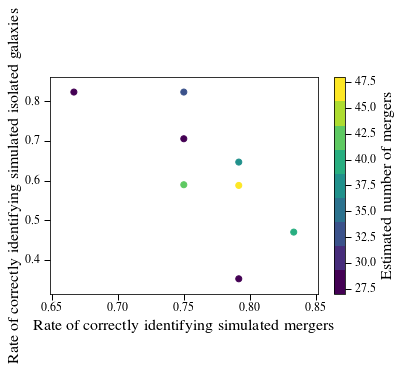

In [8]:
plt.scatter(rjs, rjps, c=Bjs, cmap=cm)
plt.xlabel(r'Rate of correctly identifying simulated mergers')
plt.ylabel(r'Rate of correctly identifying simulated isolated galaxies')
plt.colorbar(label='Estimated number of mergers')

This can be described by a beta distribution, which is just the conjugate prior to the binomial distribution. To do it correctly, we need to normalize, but I'm lazy.

In [9]:
def f_b(k, n, p):
    if p == 0:
        return 0
    elif p == 1:
        return 0
    else:
        return binom(n,k)*p**k*(1-p)**(n-k)
# The arguments are Bm, number of true underlying mergers, rj, the fraction of correctly identified mergers, rjp, the number
# of correctly identified isolated galaxies, Bj, the number of galaxies that the classifier calls mergers, B, the total
# number of galaxies in the sample, F_m, the number of fake mergers, F_I, the number of fake isolated galaxies,
# F_mhat, the number that the classifier correctly identifies as mergers, and F_Ihat, the number
# that the classifier correctly identifies as isolted galaxies.
def L(Bm, rj, rjp, Bj, B, F_m, F_I, F_mhat, F_Ihat):
    '''
    This is the likelihood for an individual classifier
    '''
    L = 0
    for k in range(min(Bj+1,int(Bm))):
        L += f_b(k, Bm, rj)*f_b(Bj-k, B-Bm, 1-rjp)
    return L*f_b(F_mhat, F_m, rj)*f_b(F_Ihat, F_I, rjp)

def lnlike(args, Bjs, B, F_m, F_I, F_mhat, F_Ihat):
    '''
    This returns the product of all of the individual classifiers' results.
    '''
    Bm, rs = args[0], args[1:]
    Bm = int(Bm)
    rjs, rjps = np.split(rs, 2)
    lnLi = 0
    for i in range(len(rjs)):
        Li = L(Bm, rjs[i], rjps[i], Bjs[i], B, F_m, F_I, F_mhat[i], F_Ihat[i])
        if Li > 0:
            lnLi += np.log(Li)
    if ~np.isfinite(lnLi):
        # Sometimes, you accidentally take the log of a negative value.
        return -np.inf
    return lnLi

def lnprior(args, B):
    Bm, rs = args[0], args[1:]
    # We demand that Bm > 1 becuase the combinatorics get nonintuitive
    # when you have things like (0 choose N) where N isn't zero.
    if (rs.min() <= 0) or (rs.max() >= 1) or (int(Bm) < 1) or (Bm > B):
        return -np.inf
    else:
        return 0
    
def lnprob(args, Bjs, B, F_m, F_I, F_mhat, F_Ihat):
    if ~np.isfinite(lnprior(args, B)):
        return -np.inf
    else:
        return lnlike(args, Bjs, B, F_m, F_I, F_mhat, F_Ihat)

In [10]:
nwalkers, ndim = 32, len(rjs)+len(rjps)+1

nwalkers = max(nwalkers, 2*ndim)

filename = "samples_8.h5"
backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

pool = Pool(nwalkers)
# pool = None
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(Bjs, B, F_m, F_I, F_mhats, F_Ihats), 
                                backend=backend, pool=pool)
try:
    coords = sampler.get_last_sample()
except AttributeError:
    print('Starting fresh')
    initial = np.array([Bjs.mean()] + rjs.tolist() + rjps.tolist())
    coords = initial*(1 + 1e-2 * np.random.randn(nwalkers, ndim))
max_n = 100000
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(coords, iterations=max_n, progress=True, skip_initial_state_check=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau
    if sampler.iteration % 10000 == 0:
        print(tau)
        print(f'{int(tau.max())*100 - sampler.iteration} to go')

        



  0%|          | 200/100000 [00:14<1:57:20, 14.17it/s]


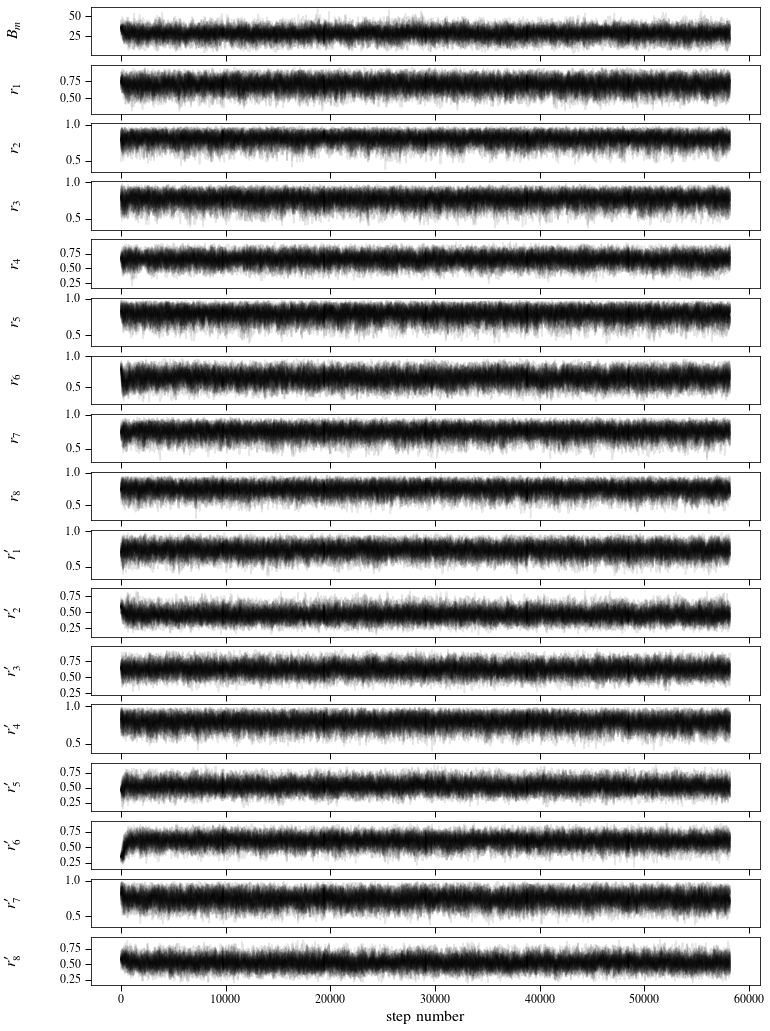

In [11]:
fig, axes = plt.subplots(nrows=ndim, figsize=(12, 18), sharex=True)

samples = sampler.get_chain(discard=0, flat=False, thin=1)

labels = [r'$B_m$'] +\
         list(map(r"$r_{{{0}}}$".format, range(1, len(rjs)+1 ))) +\
         list(map(r"$r'_{{{0}}}$".format, range(1, len(rjps)+1 )))

        
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


(array([1., 0., 2., 3., 4., 2., 0., 1., 3., 1.]),
 array([292.54415327, 298.16462776, 303.78510225, 309.40557675,
        315.02605124, 320.64652573, 326.26700023, 331.88747472,
        337.50794921, 343.12842371, 348.7488982 ]),
 <a list of 10 Patch objects>)

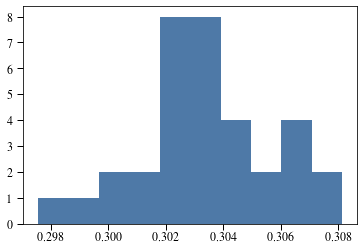

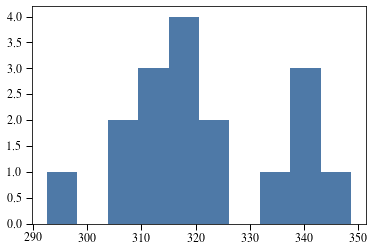

In [12]:
plt.hist(sampler.acceptance_fraction)
plt.figure()
taus = sampler.get_autocorr_time(tol=0)
plt.hist(taus)


In [13]:
samples = sampler.get_chain(discard=2*int(taus.max()), flat=True, thin=5)

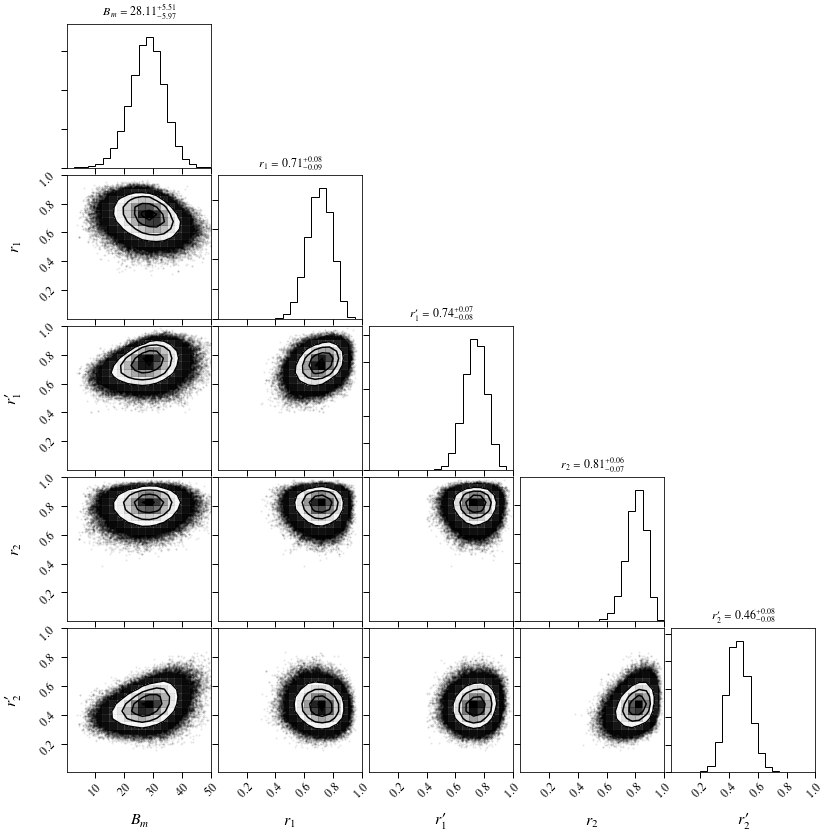

In [14]:
fig = corner(samples[:,[0,1,9,2,10]], labels=[r'$B_m$', r'$r_1$', r"$r_1'$", r'$r_2$', r"$r_2'$",],
            show_titles=True, range=[(0, 50)] + [(0,1)]*4)

burn-in: 697
thin: 146
flat chain shape: (13362, 17)
flat log prob shape: (13362,)


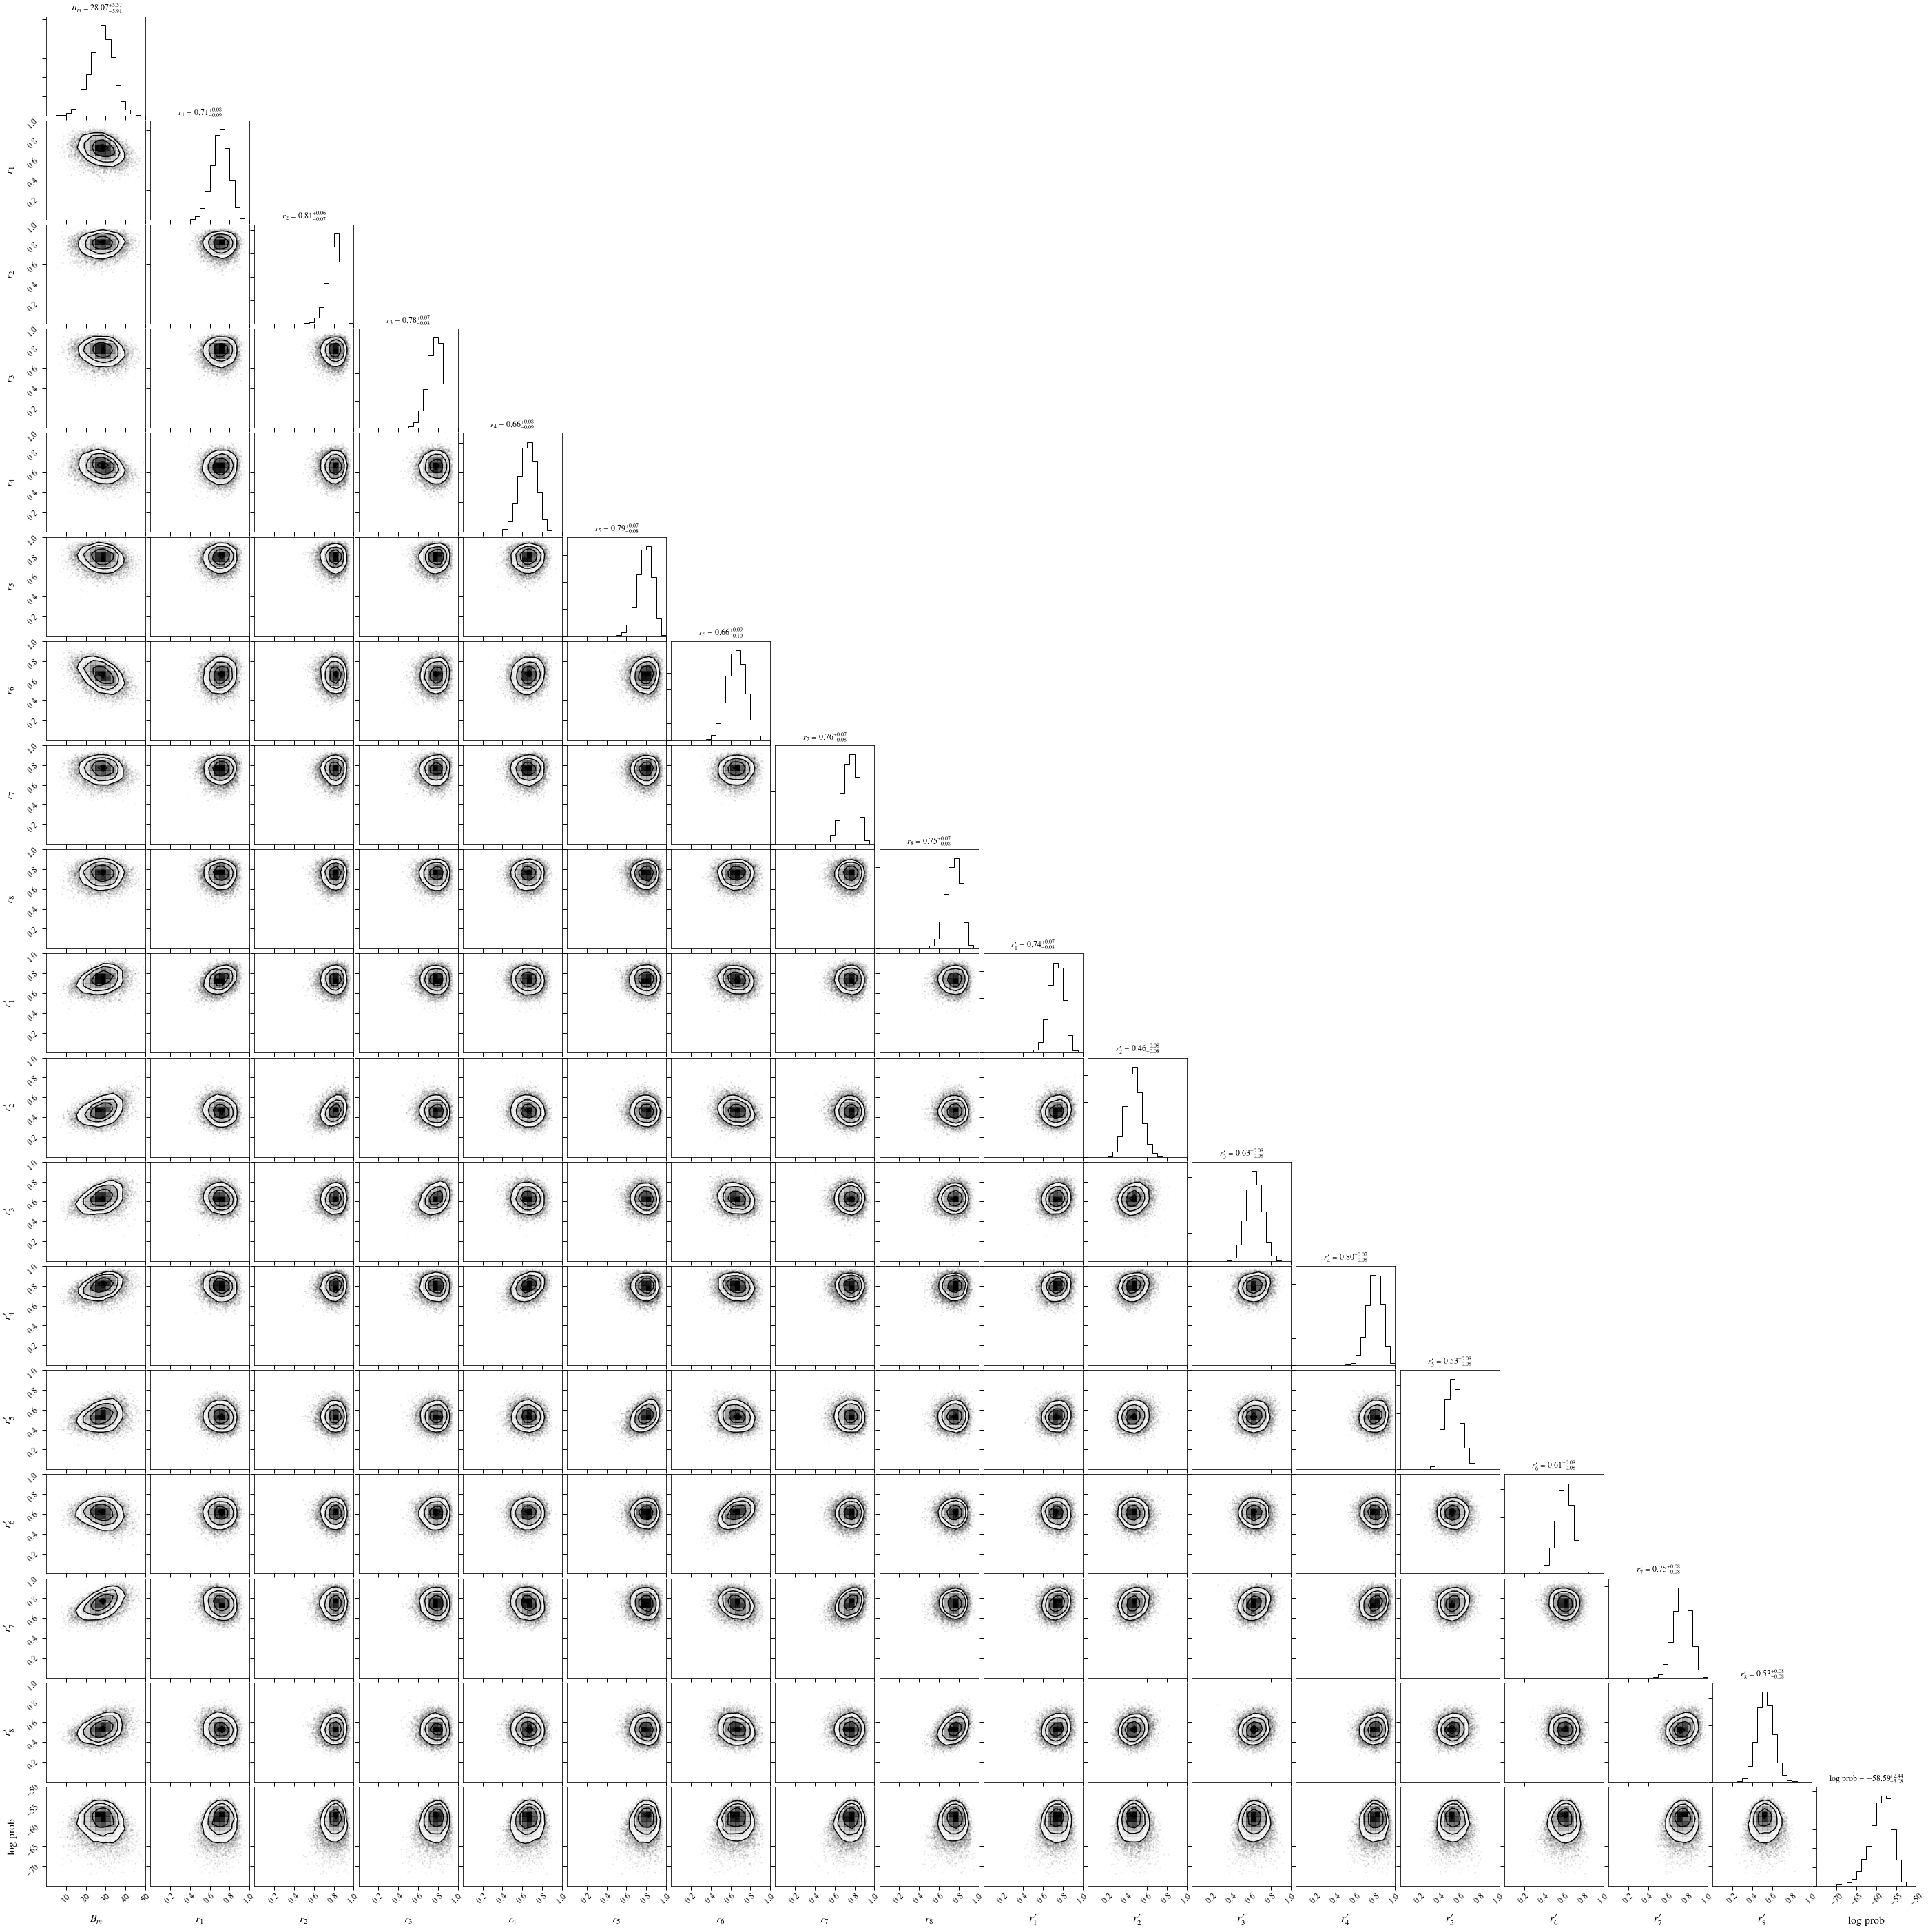

In [15]:
tau = sampler.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None]), axis=1
)

labels = [r'$B_m$'] +\
         list(map(r"$r_{{{0}}}$".format, range(1, len(rjs)+1 ))) +\
         list(map(r"$r'_{{{0}}}$".format, range(1, len(rjps)+1 )))
labels += ["log prob"]

fig = corner(all_samples, labels=labels, show_titles=True, range=[(0, 50)] + [(0,1)]*2*len(rjs) + [(-75, -50)])
plt.savefig('corner_est.pdf', bbox_inches='tight')

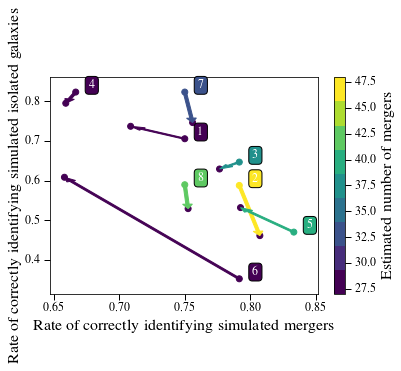

In [16]:
med = np.median(all_samples, axis=0)
Bm, rs, lnL = med[0], med[1:-1], med[-1]

rs, rps = np.split(rs, 2)

drs = rs - rjs
drjs = rps - rjps
ci = (Bjs - Bjs.min())/(Bjs.max() - Bjs.min())
plt.scatter(rjs, rjps, c=Bjs, cmap=cm)
plt.scatter(rs, rps, c=Bm*np.ones_like(rs), cmap=cm, vmin=Bjs.min(), vmax=Bjs.max())
for i in range(len(drs)):
    plt.arrow(rjs[i], rjps[i], drs[i], drjs[i], color=cm(ci[i]), width=0.0025, length_includes_head=True)
    plt.text(rjs[i] + 0.01, rjps[i] + 0.01, f'{i+1}', size=12, color='white',
                     bbox=dict(boxstyle="round",
                   fc = cm(ci[i])
                   )
)
plt.xlabel(r'Rate of correctly identifying simulated mergers')
plt.ylabel(r'Rate of correctly identifying simulated isolated galaxies')
plt.colorbar(label='Estimated number of mergers')

In [17]:
%reset -f